In [6]:
import jax
import netket as nk
import numpy as np
from netket.operator.spin import sigmax,sigmaz, sigmap, sigmam
import time
from scipy.sparse.linalg import eigsh
import jax.numpy as jnp
import matplotlib.pyplot as plt
from ladder_tool import *

L = 8
periodic = True
hi = nk.hilbert.Spin(s=1 / 2, N =  L*2)

Jv_ = [0.2, 0.4, 0.6]
Jx_ = [0.2 ,0.4 ,0.6]

cmi_single = {}
cmi_dimer = {}
cmi_traceout = {}
mean_corr_dimer= {}
var_corr_dimer = {}
mean_corr_single = {}
var_corr_single = {}
gap = {}

# Looping through the values and loading each file
for Jv in Jv_:
    for Jx in Jx_:
        filename = f"result/ladder/cmi_ladder_single_L{L}_Jv={Jv}_Jx={Jx}periodic_{periodic}.npy"
        cmi_single[Jv, Jx] = np.load(filename)
        cmi_single[Jv, Jx] = cmi_single[Jv, Jx][cmi_single[Jv, Jx]>1e-13]
        filename = f"result/ladder/cmi_ladder_dimer_L{L}_Jv={Jv}_Jx={Jx}periodic_{periodic}.npy"
        cmi_dimer[Jv, Jx] = np.load(filename)
        cmi_dimer[Jv, Jx] = cmi_dimer[Jv, Jx][cmi_dimer[Jv, Jx]>1e-13]
        if periodic == True:
            cmi_dimer[Jv, Jx] = np.flip(cmi_dimer[Jv, Jx])
        filename = f"result/ladder/cmi_ladder_traceout_L{L}_Jv={Jv}_Jx={Jx}periodic_{periodic}.npy"
        cmi_traceout[Jv, Jx] = np.load(filename, allow_pickle=True)
        for j in range(len(cmi_traceout[Jv, Jx])):
            cmi_traceout[Jv, Jx][j] = np.array(cmi_traceout[Jv, Jx][j])[np.array(cmi_traceout[Jv, Jx][j])>1e-13]

        filename = f"result/ladder/mean_corr_ladder_dimer_L{L}_Jv={Jv}_Jx={Jx}periodic_{periodic}.npy"
        mean_corr_dimer[Jv, Jx] = np.load(filename)
        if periodic == False:
            filename = f"result/ladder/var_corr_ladder_dimer_L{L}_Jv={Jv}_Jx={Jx}periodic_{periodic}.npy"
            var_corr_dimer[Jv, Jx] = np.load(filename)
            var_corr_dimer[Jv, Jx] = var_corr_dimer[Jv, Jx][mean_corr_dimer[Jv, Jx]>1e-13]
        mean_corr_dimer[Jv, Jx] = mean_corr_dimer[Jv, Jx][mean_corr_dimer[Jv, Jx]>1e-13]

        if periodic == True:
            filename = f"result/ladder/mean_corr_ladder_single_L{L}_Jv={Jv}_Jx={Jx}periodic_{periodic}.npy"
            mean_corr_single[Jv, Jx] = np.load(filename)
            mean_corr_single[Jv, Jx] = mean_corr_single[Jv, Jx][mean_corr_single[Jv, Jx]>1e-13]
        filename = f"result/ladder/gap_ladder_L{L}_Jv={Jv}_Jx={Jx}periodic_{periodic}.npy"
        gap[Jv, Jx] = np.load(filename)

In [12]:
mean_corr_dimer

{(0.2, 0.2): array([0.22188764, 0.63277493, 0.08226012, 0.09381071]),
 (0.2, 0.4): array([0.14182026, 0.46522414, 0.06809147, 0.06889746]),
 (0.2, 0.6): array([0.10678765, 0.38596952, 0.06856146, 0.06262176]),
 (0.4, 0.2): array([0.24477501, 0.69751846, 0.09347515, 0.10955979]),
 (0.4, 0.4): array([0.16994355, 0.52089554, 0.07133961, 0.07533946]),
 (0.4, 0.6): array([0.11380003, 0.40020792, 0.068285  , 0.06338697]),
 (0.6, 0.2): array([0.11498517, 0.576045  , 0.03892656, 0.0610565 ]),
 (0.6, 0.4): array([0.23036763, 0.6434329 , 0.09406859, 0.10374102]),
 (0.6, 0.6): array([0.1272178 , 0.42686361, 0.06845272, 0.0652368 ])}

In [8]:
cmi_length = []
err_cmi_length =[]
corre_length_dimer = []
err_corre_length_dimer = []
corre_length_single = []
err_corre_length_single = []
cmi_length_traceout = [[ [] for i in range(len(Jx_))] for j in range(len(Jv_))]
err_cmi_length_traceout = [ [[] for i in range(len(Jx_))] for j in range(len(Jv_))]
for a in Jv_:
    for b in Jx_:
        i = (a, b)
        df = len(cmi_dimer[i])-2
        if df>=1:
            (cmi_len, b1), residuals, _, _, _ = np.polyfit(np.arange(len(cmi_dimer[i])), -np.log(cmi_dimer[i]), 1, full=True)
            mean_x = np.mean(np.arange(len(cmi_dimer[i])))
            err = np.sqrt(residuals / df) / np.sqrt(np.sum((np.arange(len(cmi_dimer[i])) - mean_x)**2))
            cmi_length.append(1/cmi_len)
            err_cmi_length.append(err/cmi_len**2)

        df = len(mean_corr_dimer[i])-2
        if df>=1:
            (corr_len, b2), residuals, _, _, _ = np.polyfit(np.arange(len(mean_corr_dimer[i])), -np.log(np.abs(mean_corr_dimer[i])), 1, full=True)
            mean_x = np.mean(np.arange(len(mean_corr_dimer[i])))
            err = np.sqrt(residuals / df) / np.sqrt(np.sum((np.arange(len(mean_corr_dimer[i])) - mean_x)**2))
            corre_length_dimer.append(1/corr_len)
            err_corre_length_dimer.append(err/corr_len**2)

        if periodic == True:
            df = len(mean_corr_single[i])-2
            if df>=1:
                (corr_len, b2), residuals, _, _, _ = np.polyfit(np.arange(len(mean_corr_single[i])), -np.log(np.abs(mean_corr_single[i])), 1, full=True)
                mean_x = np.mean(np.arange(len(mean_corr_single[i])))
                err = np.sqrt(residuals / df) / np.sqrt(np.sum((np.arange(len(mean_corr_single[i])) - mean_x)**2))
                corre_length_single.append(1/corr_len)
                err_corre_length_single.append(err/corr_len**2)

        for i in range(len(cmi_traceout[a, b])):
            df = len(cmi_traceout[a, b][i])-2
            if df>=1:
                (cmi_len, b1), residuals, _, _, _ = np.polyfit(np.arange(len(cmi_traceout[a, b][i])), -np.log(cmi_traceout[a, b][i]), 1, full=True)
                mean_x = np.mean(np.arange(len(cmi_traceout[a, b][i])))
                err = np.sqrt(residuals / df) / np.sqrt(np.sum((np.arange(len(cmi_traceout[a, b][i])) - mean_x)**2))
                cmi_length_traceout[Jv_.index(a)][Jx_.index(b)].append(1/cmi_len)
                err_cmi_length_traceout[Jv_.index(a)][Jx_.index(b)].append(err/cmi_len**2)


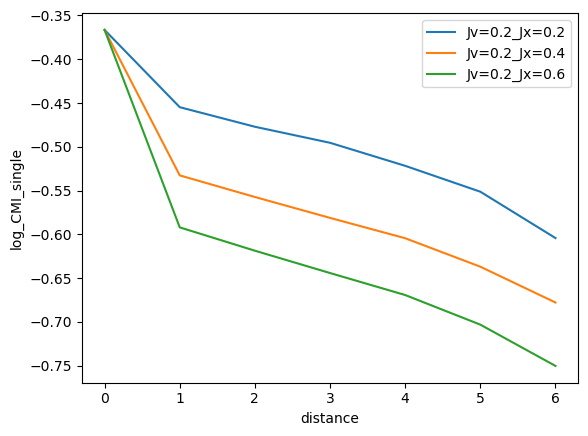

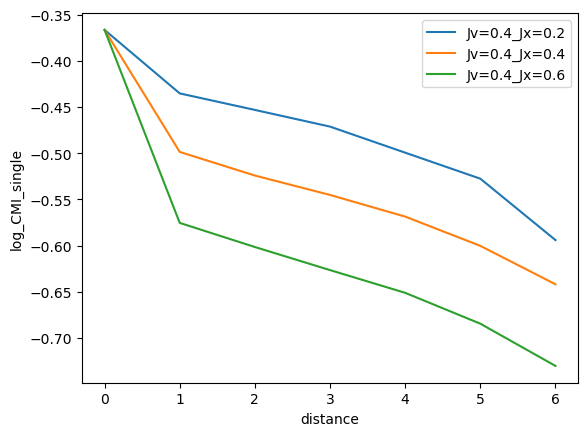

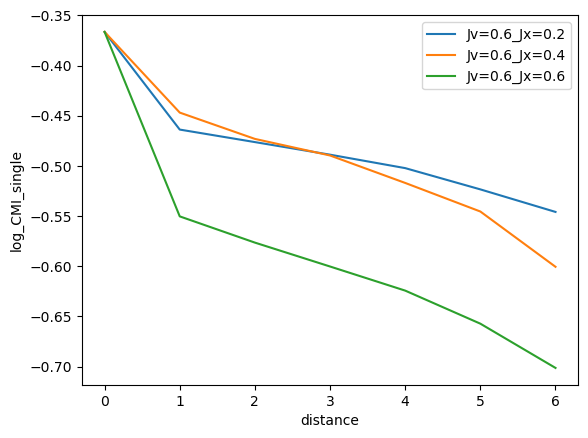

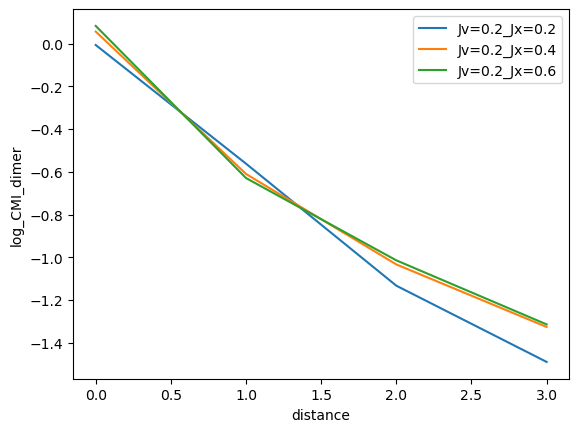

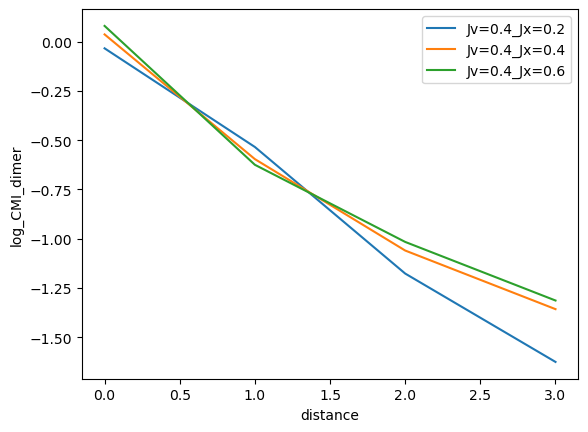

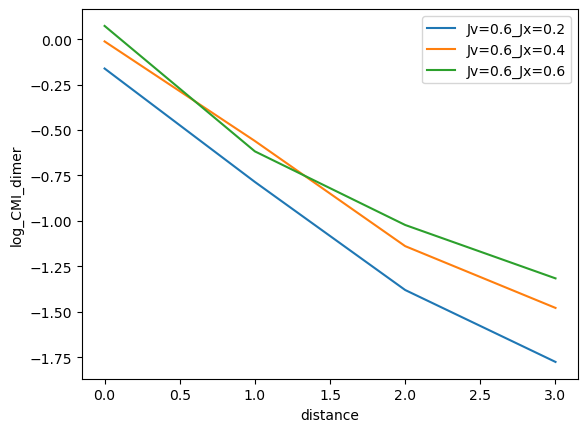

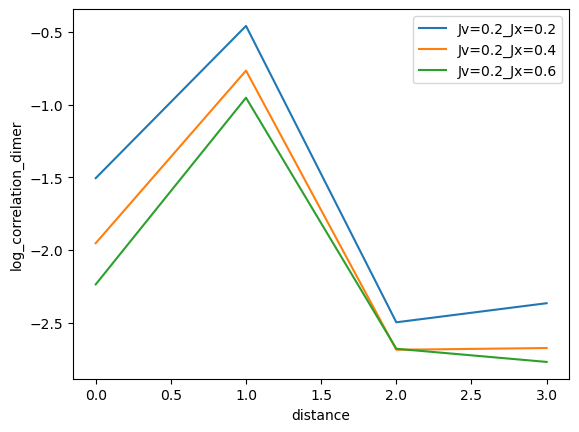

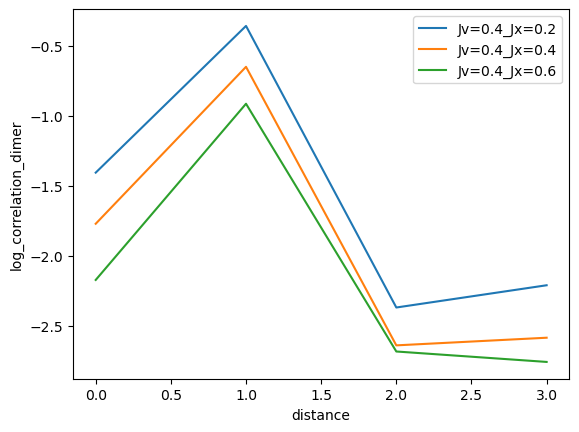

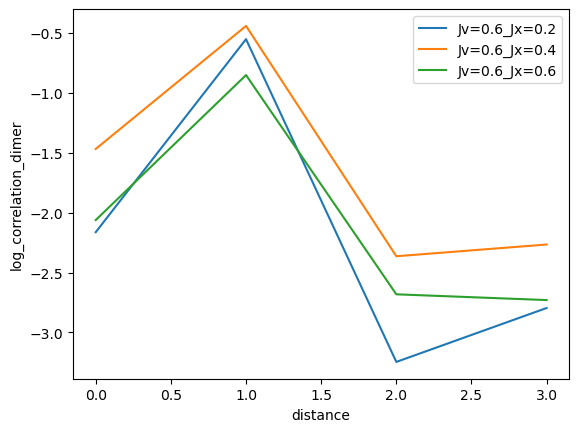

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


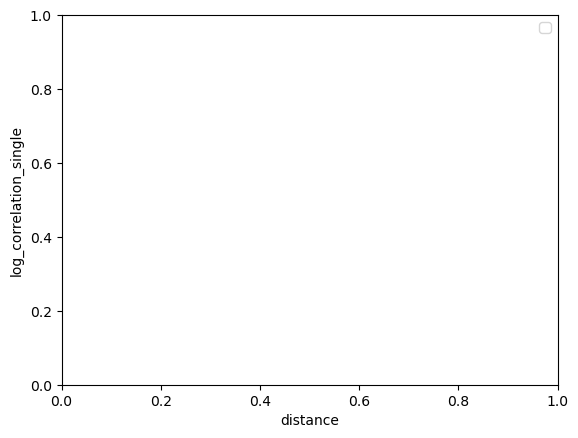

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


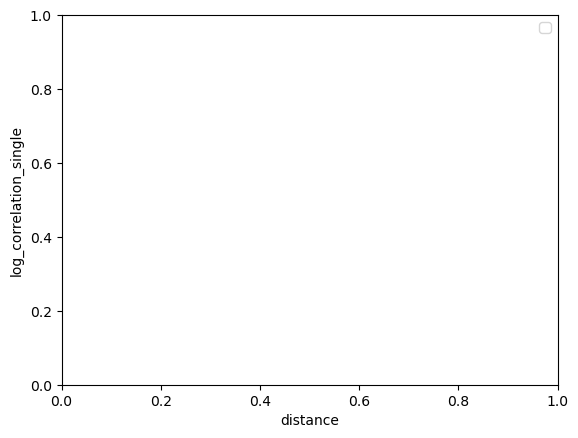

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


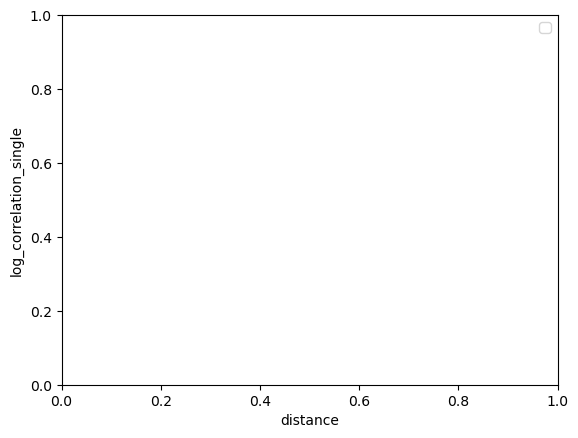

<Figure size 640x480 with 0 Axes>

In [10]:
for a in Jv_:
    for b in Jx_:
        i = (a, b)
        if len(cmi_single[i])>=3: #so that meaningful error can be got
            plt.plot(np.log(cmi_single[i]), label="Jv="+str(a)+"_Jx="+str(b))
    plt.xlabel("distance")
    plt.ylabel("log_CMI_single")
    plt.legend()
    plt.savefig("figure/ladder/cmi_single_ladder_L"+str(L)+"_Jv="+str(a)+"_periodic_"+str(periodic)+".png")
    plt.show()
    plt.clf()

for a in Jv_:
    for b in Jx_:
        i = (a, b)
        if len(cmi_dimer[i])>=3: #so that meaningful error can be got
            plt.plot(np.log(cmi_dimer[i]), label="Jv="+str(a)+"_Jx="+str(b))
    plt.xlabel("distance")
    plt.ylabel("log_CMI_dimer")
    plt.legend()
    plt.savefig("figure/ladder/cmi_dimer_ladder_L"+str(L)+"_Jv="+str(a)+"_periodic_"+str(periodic)+".png")
    plt.show()
    plt.clf()

for a in Jv_:
    for b in Jx_:
        i = (a, b)
        if len(mean_corr_dimer[i])>=3: #so that meaningful error can be got
            plt.plot(np.log(np.abs(mean_corr_dimer[i])), label="Jv="+str(a)+"_Jx="+str(b))
            if periodic == False:
                plt.fill_between(np.arange(len(mean_corr_dimer[i])) ,np.log(np.abs(mean_corr_dimer[i])) - 1/mean_corr_dimer[i]*np.sqrt(var_corr_dimer[i]) , np.log(np.abs(mean_corr_dimer[i])) + 1/np.abs(mean_corr_dimer[i])*np.sqrt(var_corr_dimer[i]), alpha=0.2)
    plt.xlabel("distance")
    plt.ylabel("log_correlation_dimer")
    plt.legend()
    plt.savefig("figure/ladder/correlation_ladder_dimer_L"+str(L)+"_Jv="+str(a)+"_periodic_"+str(periodic)+".png")
    plt.show()
    plt.clf()

if periodic == True:
    for a in Jv_:
        for b in Jx_:
            i = (a, b)
            if len(mean_corr_single[i])>=3: #so that meaningful error can be got
                plt.plot(np.log(np.abs(mean_corr_single[i])), label="Jv="+str(a)+"_Jx="+str(b))
                if periodic == False:
                    plt.fill_between(np.arange(len(mean_corr_single[i])) ,np.log(np.abs(mean_corr_single[i])) - 1/mean_corr_single[i]*np.sqrt(var_corr_dimer[i]) , np.log(np.abs(mean_corr_single[i])) + 1/np.abs(mean_corr_single[i])*np.sqrt(var_corr_dimer[i]), alpha=0.2)
        plt.xlabel("distance")
        plt.ylabel("log_correlation_single")
        plt.legend()
        plt.savefig("figure/ladder/correlation_ladder_single_L"+str(L)+"_Jv="+str(a)+"_periodic_"+str(periodic)+".png")
        plt.show()
        plt.clf()

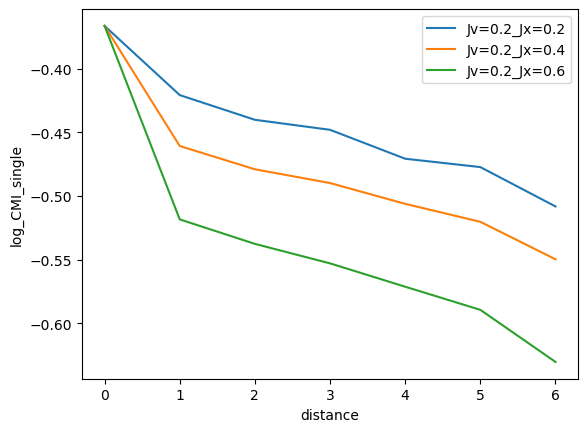

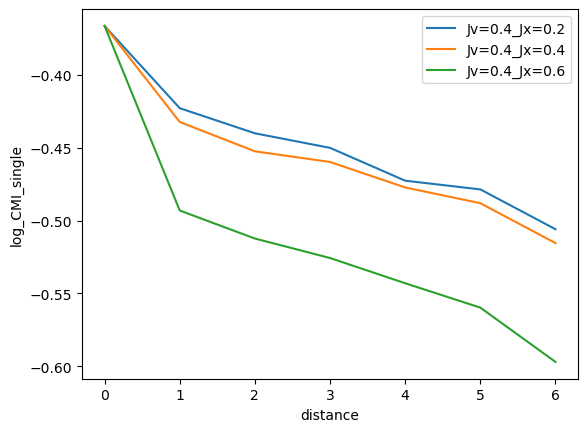

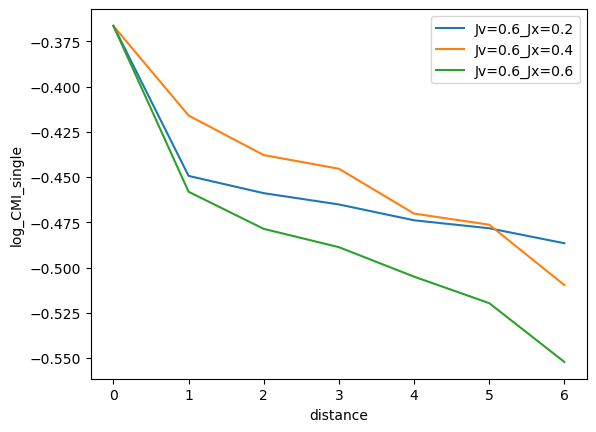

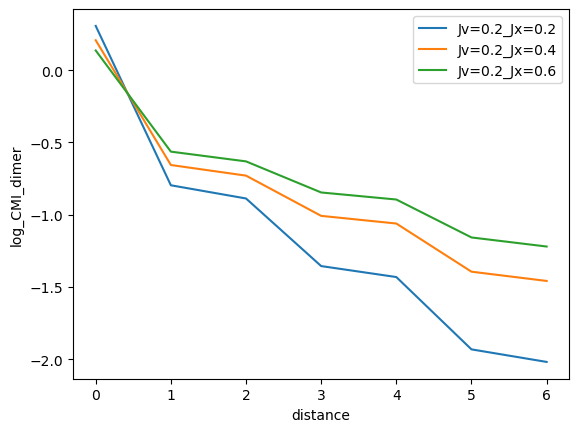

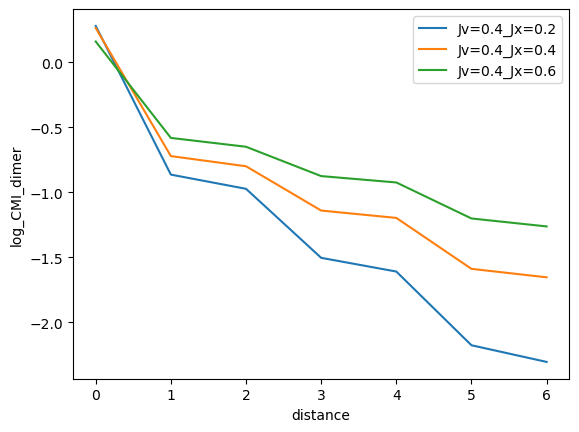

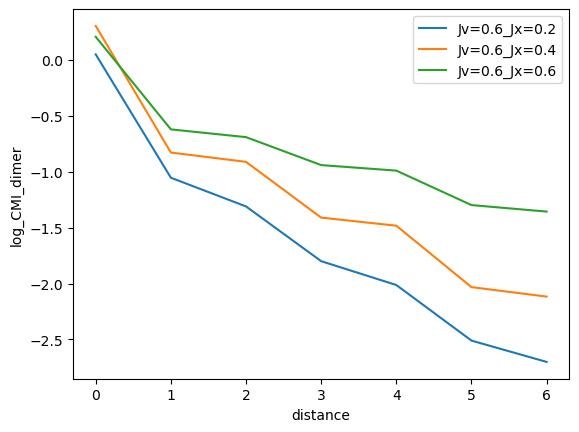

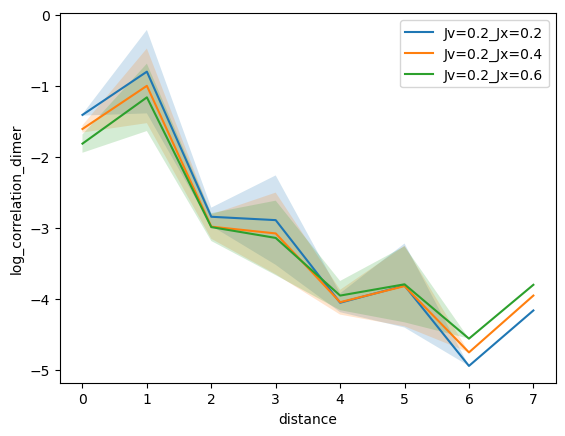

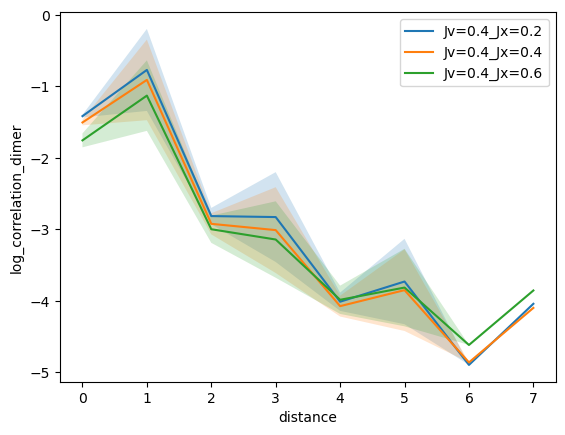

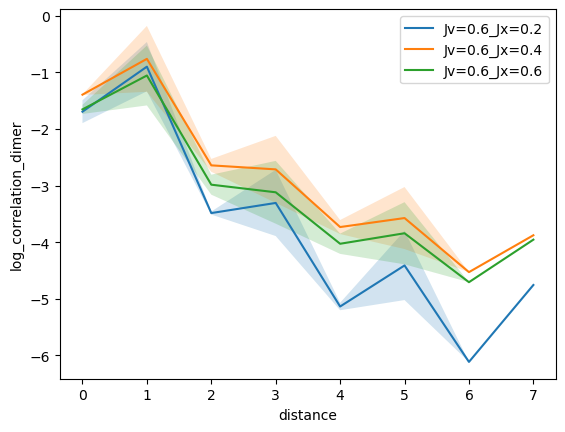

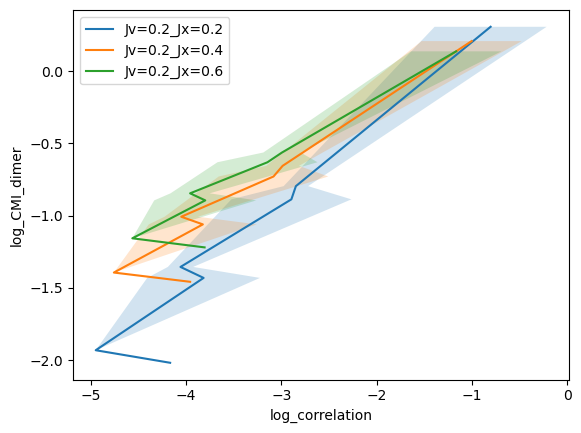

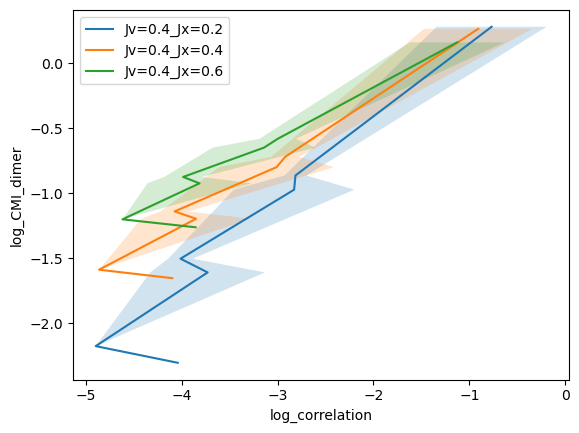

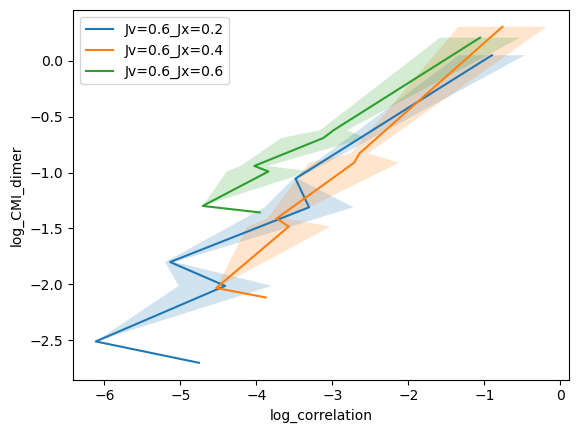

<Figure size 640x480 with 0 Axes>

In [24]:

for a in Jv_:
    for b in Jx_:
        i = (a, b)
        if periodic == False:
            plt.plot(np.log(np.abs(mean_corr_dimer[i][1:])), np.log(cmi_dimer[i]), label="Jv="+str(a)+"_Jx="+str(b))
            plt.fill_betweenx(np.log(cmi_dimer[i]), np.log(np.abs(mean_corr_dimer[i][1:])) - 1/np.abs(mean_corr_dimer[i][1:])*np.sqrt(var_corr_dimer[i][1:]) , np.log(np.abs(mean_corr_dimer[i][1:])) + 1/np.abs(mean_corr_dimer[i][1:])*np.sqrt(var_corr_dimer[i][1:]), alpha=0.2)
        else:
            plt.plot(np.log(np.abs(mean_corr_dimer[i])), np.log(cmi_dimer[i]), label="Jv="+str(a)+"_Jx="+str(b))
    plt.xlabel("log_correlation")
    plt.ylabel("log_CMI_dimer")
    plt.legend()
    plt.savefig("figure/ladder/correlation_dimer_cmi_ladder_L"+str(L)+"_Jv="+str(a)+"_periodic_"+str(periodic)+".png")
    plt.show()
    plt.clf()
if periodic == True:
    for a in Jv_:
        for b in Jx_:
            i = (a, b)
            plt.plot(np.log(np.abs(mean_corr_single[i])), np.log(cmi_dimer[i]), label="Jv="+str(a)+"_Jx="+str(b))
        plt.xlabel("log_correlation")
        plt.ylabel("log_CMI_dimer")
        plt.legend()
        plt.savefig("figure/ladder/correlation_single_cmi_ladder_L"+str(L)+"_Jv="+str(a)+"_periodic_"+str(periodic)+".png")
        plt.show()
        plt.clf()

In [8]:
print(err_corre_length_dimer)

[]


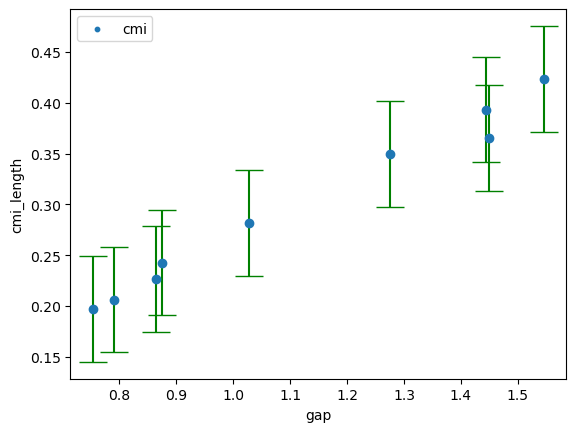

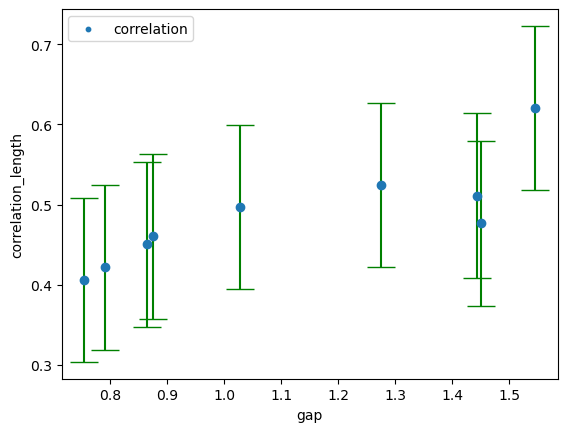

<Figure size 640x480 with 0 Axes>

In [25]:
gap_list = []
for a in Jv_:
    for b in Jx_:
        i = (a, b)
        gap_list.append(gap[i])

plt.scatter(gap_list, cmi_length, label="cmi", s=10)
plt.errorbar(gap_list, cmi_length, yerr=err_cmi_length[:][0], fmt='o', ecolor='g', capthick=1, capsize=10)
plt.xlabel("gap")
plt.ylabel("cmi_length")
plt.legend()
plt.savefig("figure/ladder/cmi_length_gap_ladder_L"+str(L)+"_periodic_"+str(periodic)+".png")
plt.show()
plt.clf()

plt.scatter(gap_list, corre_length_dimer, label="correlation", s=10)
plt.errorbar(gap_list, corre_length_dimer, yerr=err_corre_length_dimer[:][0], fmt='o', ecolor='g', capthick=1, capsize=10)
plt.xlabel("gap")
plt.ylabel("correlation_length")
plt.legend()
plt.savefig("figure/ladder/correlation_length_dimer_gap_ladder_L"+str(L)+"_periodic_"+str(periodic)+".png")
plt.show()
plt.clf()

if periodic == True:
    plt.scatter(gap_list, corre_length_single, label="correlation", s=10)
    plt.errorbar(gap_list, corre_length_single, yerr=err_corre_length_single[:][0], fmt='o', ecolor='g', capthick=1, capsize=10)
    plt.xlabel("gap")
    plt.ylabel("correlation_length")
    plt.legend()
    plt.savefig("figure/ladder/correlation_length_single_gap_ladder_L"+str(L)+"_periodic_"+str(periodic)+".png")
    plt.show()
    plt.clf()

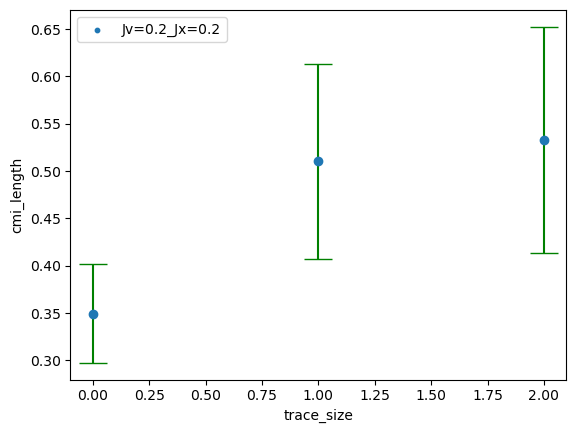

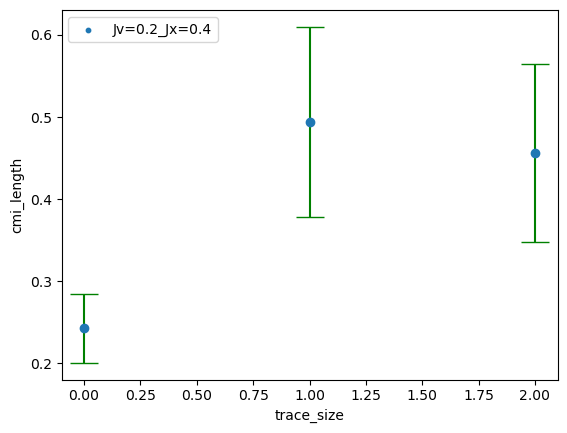

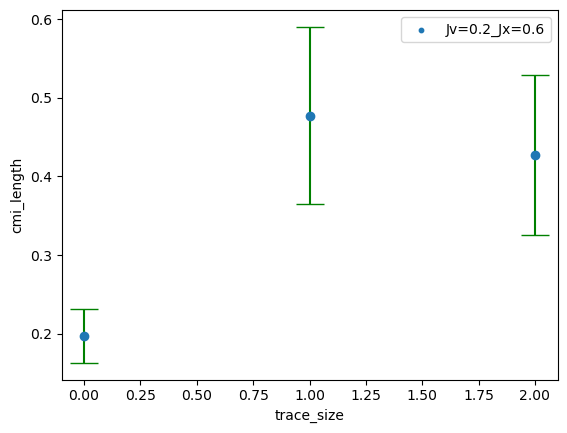

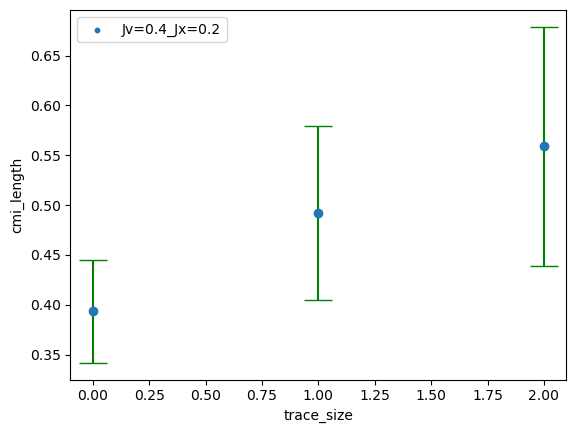

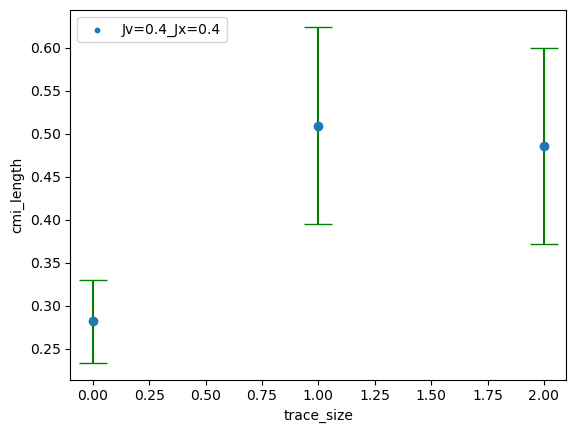

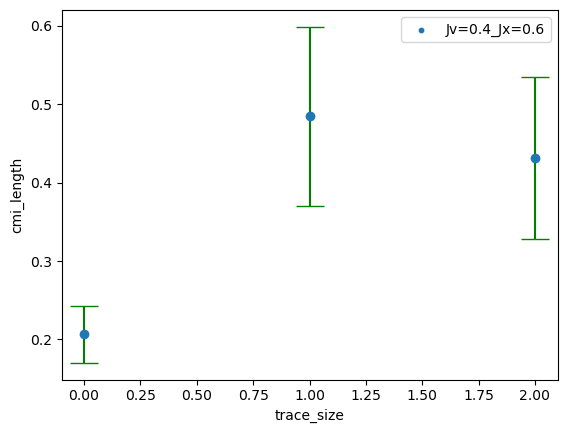

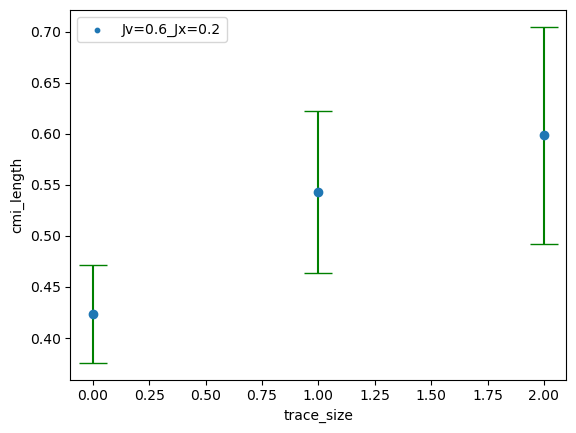

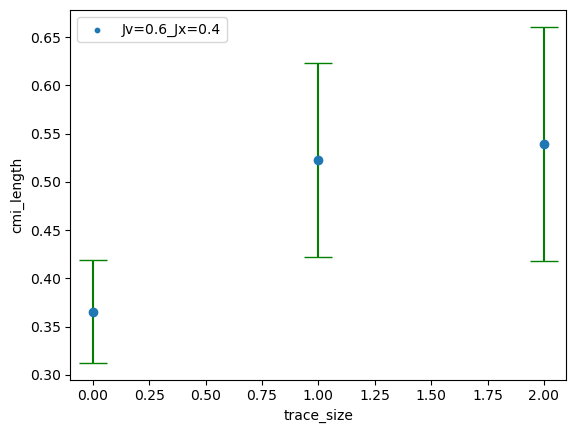

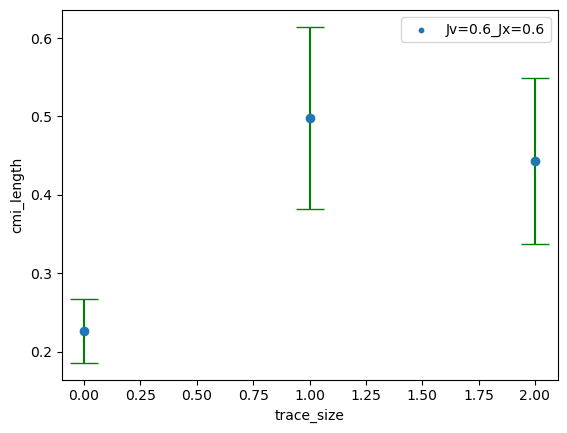

<Figure size 640x480 with 0 Axes>

In [26]:
for a in range(len(Jv_)):
    for b in range(len(Jx_)):
        plt.scatter(np.arange(len(cmi_length_traceout[a][b])), (cmi_length_traceout[a][b]), label="Jv="+str(Jv_[a])+"_Jx="+str(Jx_[b]), s=10)
        plt.errorbar(np.arange(len(cmi_length_traceout[a][b])), (cmi_length_traceout[a][b]), yerr=np.array(err_cmi_length_traceout[a][b]).ravel(), fmt='o', ecolor='g', capthick=1, capsize=10)
        plt.xlabel("trace_size")
        plt.ylabel("cmi_length")
        plt.legend()
        plt.savefig("figure/ladder/traceout/cmi_length_traceout_ladder_L"+str(L)+"Jv="+str(Jv_[a])+"_Jx="+str(Jx_[b])+"periodic_"+str(periodic)+".png")
        plt.show()
        plt.clf()

[[[0.20846623191528638, 0.48676050848447505, 0.5527580631369851],
  [0.1631687872692004, 0.48475238772077295, 0.5333273253161657],
  [0.1446655510343693, 0.4662818028381844, 0.5294640357181788]],
 [[0.22802782712429018, 0.4632831660656967, 0.5496546309725266],
  [0.17655515174317293, 0.490508476175203, 0.5413700021313995],
  [0.14762320022273284, 0.47043008762286376, 0.5295719038866499]],
 [[0.2392579538185525, 0.4852238233425015, 0.6230382306707467],
  [0.20752992739801085, 0.49300608050831896, 0.551596212079863],
  [0.15323288918940556, 0.4769820607628826, 0.5306164272974861]]]

1.23.5
